In [93]:
import torch
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')\

device

device(type='cuda')

In [94]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics



class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder):
        self.file_class = class_list
        self.image_folder = image_folder

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        preprocessing = v2.Compose([
            v2.Resize((128, 128)),
            v2.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomGrayscale(p=0.1),
            v2.RandomErasing(p=0.3),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]).to(device)

        image = preprocessing(image)

        return image, label

# Dataset split

In [95]:
train_image_label = pd.read_csv('annot/train_info.csv', names=['image_name', 'label'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)
reduced_train_df = []
for i in range(251):
    if train_df[train_df['label'] == i].shape[0] > 100:
        # If there are more than 200 samples, sample 100
        reduced_train_df.append(train_df[train_df['label'] == i].sample(100, random_state=42))
    else:
        # If there are less than 200 samples, take all available samples
        reduced_train_df.append(train_df[train_df['label'] == i])

reduced_train_df = pd.concat(reduced_train_df, ignore_index=True)

e:\AI2025\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3850982].


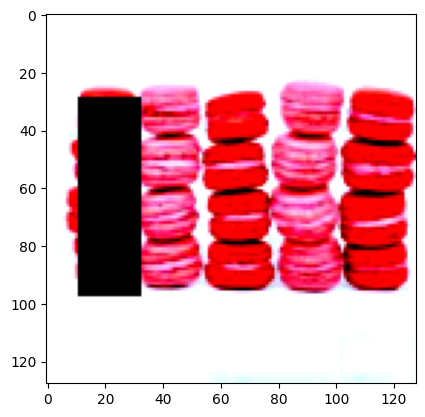

In [96]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [97]:
test_df = pd.read_csv('annot/val_info.csv')

test_dataset = FoodDataset(test_df, 'val/val_set')
test_dataset.__getitem__(0)

e:\AI2025\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(tensor([[[-1.3302, -1.0048, -0.6452,  ...,  2.1119,  2.1290,  2.1975],
          [-1.7754, -1.5014, -1.1760,  ...,  2.1119,  2.1633,  2.1633],
          [-0.9534, -1.1418, -1.2445,  ...,  2.1290,  2.1804,  2.1633],
          ...,
          [ 1.7009,  1.7180,  1.7009,  ...,  1.4612,  1.5125,  1.6324],
          [ 1.6324,  1.6667,  1.6667,  ...,  1.5982,  1.5125,  1.5639],
          [ 1.5468,  1.6495,  1.5468,  ...,  1.5639,  1.4269,  1.4440]],
 
         [[-1.1954, -0.8277, -0.4251,  ...,  2.0959,  2.1310,  2.2360],
          [-1.5455, -1.3004, -0.9853,  ...,  2.2010,  2.2360,  2.2535],
          [-0.7927, -1.0378, -1.1429,  ...,  2.2535,  2.2710,  2.2535],
          ...,
          [ 1.7458,  1.7983,  1.8333,  ...,  1.4307,  1.5007,  1.6057],
          [ 1.7283,  1.7808,  1.8158,  ...,  1.5007,  1.4657,  1.5182],
          [ 1.4832,  1.6583,  1.5882,  ...,  1.4482,  1.3256,  1.4132]],
 
         [[-0.6890, -0.3927, -0.0615,  ...,  2.0997,  2.1694,  2.3088],
          [-0.9504, -0.7936,

In [98]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [99]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# classes: array of 0 to 250
# y_train: list of labels for your training set
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(251), y=train_df.label)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights)


In [100]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


In [101]:
class FastFoodCNN(nn.Module):
    def __init__(self, num_classes=251):
        super(FastFoodCNN, self).__init__()
        
        def dw_sep_conv_se(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c),
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                SEBlock(out_c)  # ← Attention over channels
            )

        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            dw_sep_conv_se(64, 128),
            nn.MaxPool2d(2),

            dw_sep_conv_se(128, 256),
            nn.MaxPool2d(2),

            dw_sep_conv_se(256, 512),
            nn.AdaptiveAvgPool2d((1, 1))
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [102]:
cnn = FastFoodCNN(num_classes=251)
cnn.to(device)

total_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 354,739


In [103]:
#train loop
num_epochs = 50
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

shutil.rmtree('runs/food_classification', ignore_errors=True)  # Clear previous runs
writer = SummaryWriter('runs/food_classification')

training_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)
validation_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)

training_per_batch_losses = []
training_per_batch_accuracies = []
validation_per_batch_losses = []
validation_per_batch_accuracies = []

for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()

        training_per_batch_accuracies.append(training_accuracy(outputs, labels).item())
        training_per_batch_losses.append(loss.item())

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_dataloader) + len(images)*i)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
    
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            validation_per_batch_accuracies.append(validation_accuracy(outputs, labels).item())
            loss = criterion(outputs, labels)
            validation_per_batch_losses.append(loss.item())
        accuracy = 100 * (correct / total)
        print(f'Validation Accuracy: {accuracy:.2f}%')
    scheduler.step(loss)
    

  0%|          | 0/196 [00:00<?, ?it/s]e:\AI2025\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
  5%|▍         | 9/196 [00:05<02:03,  1.51it/s]


KeyboardInterrupt: 

In [ ]:
accuracy = 100 * (correct / total)
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 5.03%


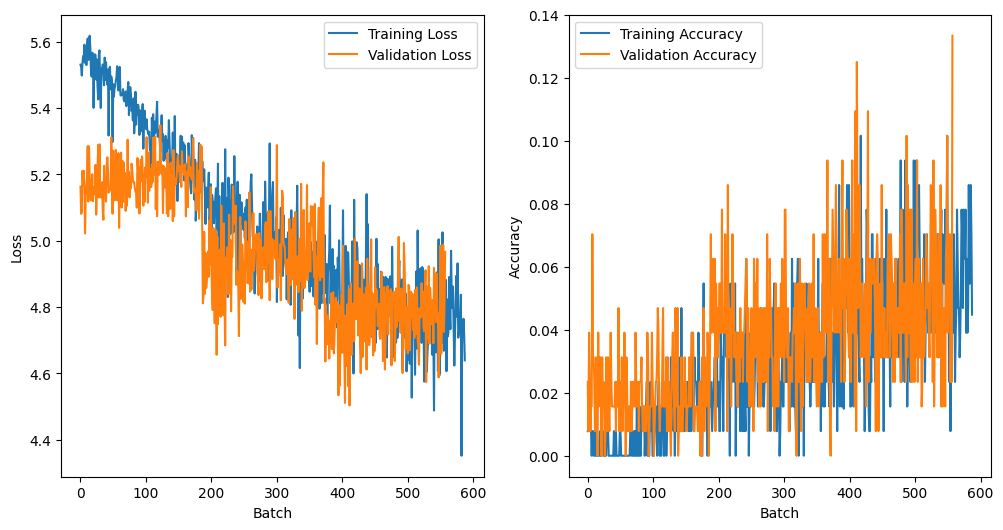

In [ ]:
#plot losses and accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_per_batch_losses, label='Training Loss')
plt.plot(validation_per_batch_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training_per_batch_accuracies, label='Training Accuracy')
plt.plot(validation_per_batch_accuracies, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()